<a href="https://colab.research.google.com/github/tsiligardi/PRA3024-Analysis-of-big-data-in-physics/blob/main/LHCb_no_root_ipynb_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**File handaling**<br>
Install all the libraries needed for the code

In [ ]:
#try not to use extended function, but just normal ones and see what happen
#when you do it, for the plotting and in the for ..... frac in ..... (model.get_params())
#try to use the NLL fitting and increase the binning
!pip install uproot awkward lz4 xxhash
!pip install zfit
!pip install mplhep


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import uproot
f=uproot.open ("/content/drive/MyDrive/B2HHH_MagnetDown.root")
f.keys()

['DecayTree;1']

In [ ]:
from numpy import *
import matplotlib
import matplotlib.pyplot as plt


In [ ]:
tree=f["DecayTree"].arrays(library="np")

**Defining classes and useful functions**<br>
In this cell, I defined a class and some functions to avoid repetitions in the code, in particular
<ul>
<li> The class Daughter, which creates a daughter particle given the tree and the number (1,2, or 3), retrieving information about its momentum on the three components, the probabilities of being a kaon or a pion, calculating its total momentum. In addition, it has also a method to calculate the total energy of the particle. Although this may be an unusual approach, in my opinion, it simplifies the readability of the code and the accessibility of the information 
<li> A function to create three daughter particles given the tree
<li> A function to calculate the total momentum of the mother and a function to calculate its mass
<li> a function to plot simple histogram(s)
<li> A function to fit and plot the fitted the model
<li> A function to calculate the asymmetry and one for its uncertainty


</ul>


In [ ]:
#defining useful classes and functions
class Daughter:
  def __init__(self, tree, number):
    self.PX=tree["H{}_PX".format(number)]
    self.PY=tree["H{}_PY".format(number)]
    self.PZ=tree["H{}_PZ".format(number)]
    self.PTOT=sqrt(square(self.PX)+square(self.PY)+square(self.PZ))#total momentum of the daughter particle
    self.ProbK=tree["H{}_ProbK".format(number)]
    self.ProbPi=tree["H{}_ProbPi".format(number)]
    
  def getTotalEnergy(self, mass):
    return  sqrt(square(self.PTOT)+mass**2)#total energy of the particle

def getDaughterParticles(tree):
  daughters=[]
  for i in range(1,4):
    daughters.append(Daughter(tree,i))
  return daughters


def totalMomentumMother(H1,H2,H3):
  return sqrt(square(H1.PX+H2.PX+H3.PX)+square(H1.PY+H2.PY+H3.PY)+square(H1.PZ+H2.PZ+H3.PZ))

def massMother(H1,H2,H3,mass):
  return sqrt(square(H1.getTotalEnergy(mass)+H2.getTotalEnergy(mass)+H3.getTotalEnergy(mass))-square(totalMomentumMother(H1,H2,H3)))

def plotHists(data,bins,range,labels=None,title=None,xlabel=None,ylabel=None,grid=False,loc="upper right"):
  for dat in data:
    plt.hist(dat,bins,range,histtype='step');
  if labels: plt.legend(labels,loc=loc); 
  if title : plt.title(title); 
  if xlabel: plt.xlabel(xlabel);  
  if ylabel: plt.ylabel(ylabel);  
  if grid: plt.grid();  
  plt.show()
  return None

def getModel(model,data,bins=300,title=None,limits=(5200,5800)): 
  #binning
  binning = zfit.binned.RegularBinning(bins, limits[0],limits[1], name="mass")
  mass_binned = zfit.Space("mass", binning=binning)
  data_binned = data.to_binned(mass_binned)
  model_binned = zfit.pdf.BinnedFromUnbinnedPDF(model, mass_binned)
  #fitting
  nll = zfit.loss.ExtendedBinnedChi2(model_binned, data_binned)
  minimizer = zfit.minimize.Minuit()
  result = minimizer.minimize(nll)
  result.hesse()
  print(result.info['minuit'])
  #chi2
  chi2=result.fmin
  #dof=len(data.to_pandas())-len(model.get_params())
  dof=bins-len(model.get_params())
  #plotting, taken and modified from https://indico.cern.ch/event/882824/contributions/3932489/:
  lower, upper = data.data_range.limit1d
  counts, bin_edges = histogram(data.to_pandas(), bins=bins)
  plt.figure(figsize=(10,6))
  mplhep.histplot(counts, bins=bin_edges, histtype="errorbar", yerr=True, label="Data", color="black")
  binwidth = diff(bin_edges)[0]
  x = linspace(lower, upper, num=1000)
  y = model.ext_pdf(x) * binwidth
  plt.plot(x,y,label="model",color="blue")
  for mod, lab, col  in zip(model.get_models(),["signal","background"],["red","green"]):
    y_m=mod.ext_pdf(x) * binwidth
    plt.plot(x,y_m,label=lab,color=col,ls="--")
  plt.legend(loc="upper right")
  if title:
    plt.title(title)
  plt.show()
  return result.params,chi2/dof
'''

def getModel(model,data,bins=300,title=None):# inspired from https://www.youtube.com/watch?v=YDW-XxrSbns:
  data_to_plot=data.to_pandas()
  #fitting
  nll = zfit.loss.ExtendedUnbinnedNLL(model, data)
  minimizer = zfit.minimize.Minuit()
  result = minimizer.minimize(nll)
  result.hesse()
  print(result.info['minuit'])
  #chi2
  chi2=-2*result.fmin
  dof=len(data_to_plot)-len(result.params)
  #plotting
  lower, upper = data.data_range.limit1d
  counts, bin_edges = histogram(data_to_plot, bins=bins)
  plt.figure(figsize=(10,6))
  mplhep.histplot(counts, bins=bin_edges, histtype="errorbar", yerr=True, label="Data", color="black")
  binwidth = diff(bin_edges)[0]
  x = linspace(lower, upper, num=1000)
  y = model.ext_pdf(x) * binwidth
  plt.plot(x,y,label="model",color="blue")
  for mod, lab, col  in zip(model.get_models(),["signal","background"],["red","green"]):
    y_m=mod.ext_pdf(x) * binwidth
    plt.plot(x,y_m,label=lab,color=col,ls="--")
  plt.legend(loc="upper right")
  if title:
    plt.title(title)
  plt.show()
  return result.params,chi2/dof

'''

def asymmetry(Nplus, Nminus):
  return (Nminus-Nplus)/(Nminus+Nplus)

def deviation(Nplus, Nminus):
  return sqrt((1-asymmetry(Nplus, Nminus)**2)/(Nminus+Nplus))






In [ ]:
#creating the istances for the three daughter particles
H1,H2,H3=getDaughterParticles(tree)


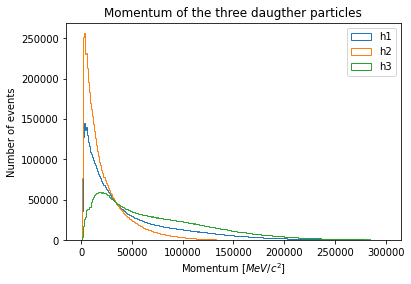

In [ ]:
#plotting the hystogram

bins=300
range_hist=(0,300000)

plotHists([H1.PTOT,H2.PTOT,H3.PTOT],bins,range_hist,title="Momentum of the three daugther particles",xlabel='Momentum [$MeV/c^2$]'
,ylabel='Number of events',labels=['h1','h2','h3'])



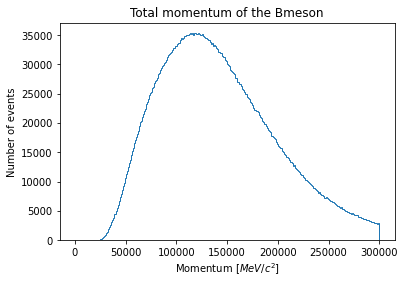

In [ ]:
#Calculating the total momentum of the mother 
mother_ptot=totalMomentumMother(H1,H2,H3)


plotHists([mother_ptot],bins,range_hist,title="Total momentum of the Bmeson",xlabel='Momentum [$MeV/c^2$]'
,ylabel='Number of events')

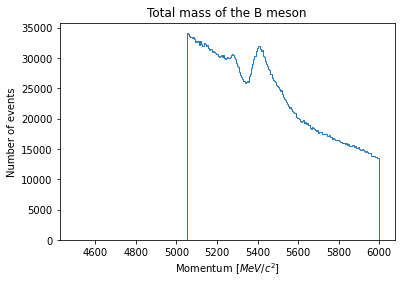

In [ ]:
#total mass of the mother
massK=493.677
mass_mother=massMother(H1,H2,H3,massK)

range_hist=(4500,6000)

plotHists([mass_mother],bins,range_hist,title="Total mass of the B meson",xlabel='Momentum [$MeV/c^2$]'
,ylabel='Number of events')
#Does this match what we would expect from theory?

According to Wikipedia (https://en.wikipedia.org/wiki/B_meson), the mass for B meson is $5279.34\  MeV/c^2$. The histogram has three peaks: 
<ul>
<li> The highest around $5000\  MeV/c^2$
<li> A second one between $5200\  MeV/c^2$ and $5400\  MeV/c^2$ (which correspond to the theoretical mass of B mesons)
<li> A third one around $5400\  MeV/c^2$
</ul>
Considering that no filter has been applied yet and, therefore, there are also data about particles that are not B meson, the results seem reasonable.

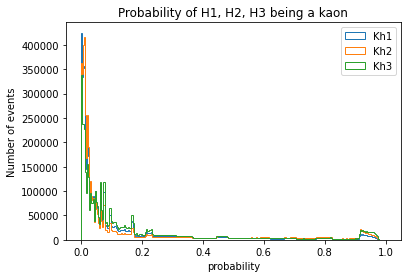

In [ ]:
#Make plots of H1/H2/H3 _ProbK on one plot

range_hist=(0,1)

plotHists([H1.ProbK,H2.ProbK,H3.ProbK],bins,range_hist,title="Probability of H1, H2, H3 being a kaon",xlabel='probability'
,ylabel='Number of events',labels=['Kh1','Kh2','Kh3'])


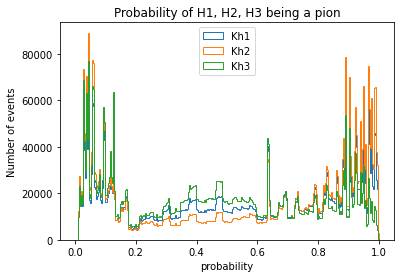

In [ ]:
#Make plots of H1/H2/H3 _ProbPi on one plot
range_hist=(0,1)

plotHists([H1.ProbPi,H2.ProbPi,H3.ProbPi],bins,range_hist,title="Probability of H1, H2, H3 being a pion",xlabel='probability'
,ylabel='Number of events',labels=['Kh1','Kh2','Kh3'],loc="upper center")


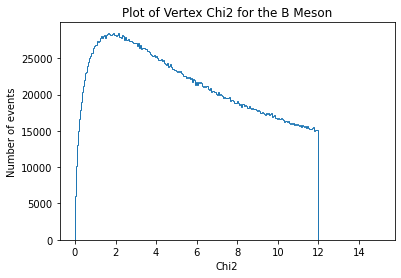

In [ ]:
#make a plot of the B_VertexChi2
range_hist=(0,15)

plotHists([tree["B_VertexChi2"]],bins,range_hist,title="Plot of Vertex Chi2 for the B Meson",xlabel='Chi2'
,ylabel='Number of events')


Based on the previous plots, it was decided to keep the data relative to those particles whose probability to be a Kion is more than 50%, that are not muon and whose probability to be a pion is less tha 0.15%

In [ ]:
#Making the selction
selection="(H1_ProbK>0.5) & (H2_ProbK>0.5) & (H3_ProbK>0.5) & (H1_ProbPi<0.15) & (H1_isMuon==0) & (H2_isMuon==0) &(H3_isMuon==0)& (H2_ProbPi<0.15) & (H3_ProbPi<0.15)"
cutTree=f["DecayTree"].arrays(library="np",cut=selection)



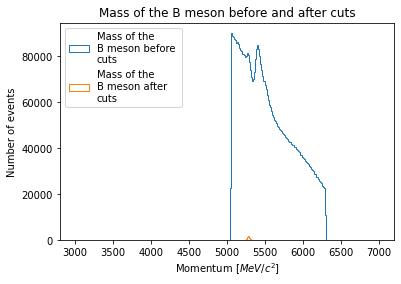

In [ ]:
H1_cut,H2_cut,H3_cut=getDaughterParticles(cutTree)

range_hist=(3000,7000)
mass_mother_cut=massMother(H1_cut,H2_cut,H3_cut,massK)

plotHists([mass_mother,mass_mother_cut],bins,range_hist,title="Mass of the B meson before and after cuts",xlabel='Momentum [$MeV/c^2$]'
,ylabel='Number of events',labels=["Mass of the \nB meson before \ncuts","Mass of the \nB meson after \ncuts"],loc="upper left")



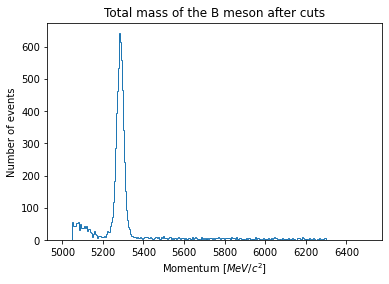

In [ ]:
#mother cut alone

range_hist=(5000,6500)

plotHists([mass_mother_cut],bins,range_hist,title="Total mass of the B meson after cuts",xlabel='Momentum [$MeV/c^2$]'
,ylabel='Number of events')


#What do you notice about your histogram now?


The histogram is now way narrower, with the peak between $5200\  MeV/c^2$ and $5400\  MeV/c^2$ (which correspond to the mass of the B mesons). However, the number of events is greatly reduced. 

In [ ]:
import zfit
import mplhep

/usr/local/lib/python3.8/dist-packages/zfit/__init__.py:62: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


In [ ]:
mass=zfit.Space("mass",limits=(5200,5800))
data = zfit.Data.from_numpy(obs=mass, array=mass_mother_cut)#selecting the data in that range

#signal
gauss_mean=zfit.Parameter("mean",5300,5200,5600)
gauss_width=zfit.Parameter("sd",15,10,20)
gauss_norm=zfit.Parameter("signal yield",len(data.to_pandas())/30, 0, len(data.to_pandas())*3)


#background
lam=zfit.Parameter("lambda",-0.02, -2, +2)
exp_norm=zfit.Parameter("background yield",len(data.to_pandas())/30, 0, len(data.to_pandas())*2)


/usr/local/lib/python3.8/dist-packages/zfit/_loss/binnedloss.py:511: AdvancedFeatureWarning: Either you're using an advanced feature OR causing unwanted behavior. To turn this warning off, use `zfit.settings.advanced_warnings['chi2_counts_small'] = False`  or 'all' (use with care) with `zfit.settings.advanced_warnings['all'] = False
Some values in                  ┌───────────────────────────────────────────────────────────┐
[5200, 5202) 4   │▉                                                          │
[5202, 5204) 5   │█▏                                                         │
[5204, 5206) 4   │▉                                                          │
[5206, 5208) 5   │█▏                                                         │
[5208, 5210) 4   │▉                                                          │
[5210, 5212) 5   │█▏                                                         │
[5212, 5214) 4   │▉                                                          │
[5214, 5216) 4   │

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 26.86                      │              Nfcn = 232              │
│ EDM = 9.4e-06 (Goal: 0.001)      │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬────

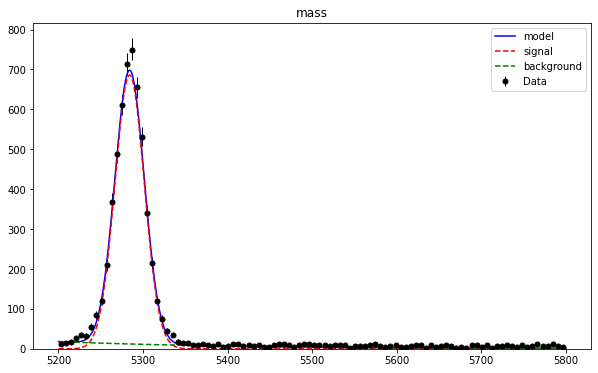

In [ ]:
#creating the model
limits=(5200,5400)
bins=100
signal=zfit.pdf.Gauss(obs=mass, mu=gauss_mean, sigma=gauss_width).create_extended(gauss_norm)
bckg=zfit.pdf.Exponential(lam, obs=mass).create_extended(exp_norm)

model=zfit.pdf.SumPDF([signal,bckg])

#getting the model
result,chi2=getModel(model,data,title="mass",limits=limits,bins=bins)


In [ ]:
print("signal yield: ",result[gauss_norm]["value"],"+/-",result[gauss_norm]['hesse']['error'])
print("background yield: ",result[exp_norm]["value"],'+/-',result[exp_norm]['hesse']['error'])
print("chi2:",chi2)

signal yield:  4979.368834580966 +/- 87.42379645241037
background yield:  591.3015855503567 +/- 57.04736909794058
chi2: 0.28270106732534717


**Counting**

In [ ]:
totalCharge= "H1_Charge+H2_Charge+H3_Charge"
#filtering by charge
B_minus=f["DecayTree"].arrays(cut="({}==-1)&{}".format(totalCharge,selection), library="np")
B_plus=f["DecayTree"].arrays(cut="({}==1)&{}".format(totalCharge,selection), library="np")


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 34.32                      │              Nfcn = 180              │
│ EDM = 0.000261 (Goal: 0.001)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬────

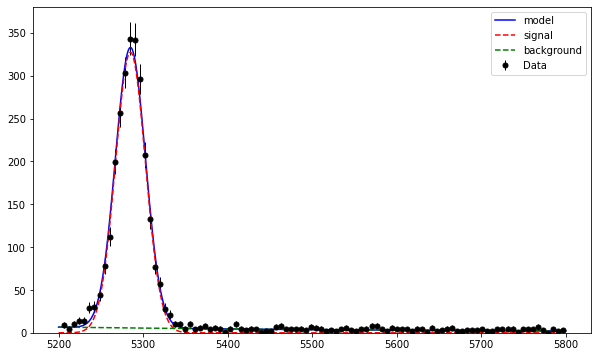

In [ ]:
#Model B_minus
H1_Bminus,H2_Bminus,H3_Bminus=getDaughterParticles(B_minus)
mass_mother_Bminus=massMother(H1_Bminus,H2_Bminus,H3_Bminus,massK)


data_B_minus=zfit.Data.from_numpy(obs=mass, array=mass_mother_Bminus)#selecting the data in that range

params,chi_2_minus=getModel(model,data_B_minus,bins=bins)
N_minus=params[gauss_norm]["value"]

In [ ]:
print("N minus: ",N_minus,"\nchi2 minus:",chi_2_minus)

N minus:  2446.4078051328383 
chi2 minus: 0.3612233249268809


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 115.7                      │              Nfcn = 131              │
│ EDM = 2.3e-05 (Goal: 0.001)      │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬────

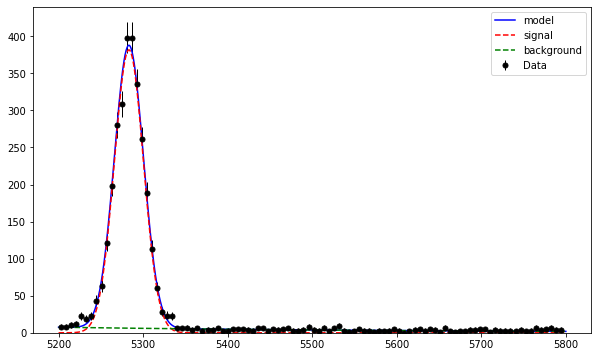

In [ ]:
#Model B_plus
H1_Bplus,H2_Bplus,H3_Bplus=getDaughterParticles(B_plus)
mass_mother_Bplus=massMother(H1_Bplus,H2_Bplus,H3_Bplus,massK)

data_B_plus=zfit.Data.from_numpy(obs=mass, array=mass_mother_Bplus)

params,chi_2_plus=getModel(model,data_B_plus,bins=bins)
N_plus=params[gauss_norm]["value"]


In [ ]:
print("N plus: ",N_plus,"\nchi2 plus:",chi_2_plus)

N plus:  2752.868751353822 
chi2 plus: 1.2179393080468117


In [ ]:
print("asymmetry: ",asymmetry(Nminus=N_minus,Nplus=N_plus),"\nuncertainty:",deviation(Nminus=N_minus,Nplus=N_plus))

asymmetry:  -0.0589429977212196 
uncertainty: 0.013844357241994404


The results show indeed an asymmetry between the B+ meson and B-. This prevalence of matter over anti-matter is why we (and the entire universe) exist. 

**A note on the $\chi^2$ values**<br>
The $\chi^2$ should be close to 1, however, this does not always happens in these fitting and, sometimes, it even gives negative values (this is possible in fit because of the way the $\chi^2$ is calculated). The poor results may depend on multiple factors:
<ul>
<li>A bad choice for the fitting function (the exponential+gaussian may not be the best choice here)
<li>A bad fitting procedure. Tensors flow gives some warnings about using this method for fitting the data set. I also tried other options (Binned and Unbinned negative likelihood, and then calculating the $chi^2$) but the 
`ExtendedBinnedChi2`
is the one that gives me the best Chi 2 values
<li>The way I am calculating the reduced Chi 2 value, which was deduced based on the documentation of zfit, and may be wrong. 
</ul>
